### Problem 2: CART-RF-ANN

An Insurance firm providing tour insurance is facing higher claim frequency. The management decides to collect data from the past few years. You are assigned the task to make a model which predicts the claim status and provide recommendations to management. Use CART, RF & ANN and compare the models' performances in train and test sets.

Attribute Information:

1. Target: Claim Status (Claimed)
2. Code of tour firm (Agency_Code)
3. Type of tour insurance firms (Type)
4. Distribution channel of tour insurance agencies (Channel)
5. Name of the tour insurance products (Product)
6. Duration of the tour (Duration)
7. Destination of the tour (Destination)
8. Amount of sales of tour insurance policies (Sales)
9. The commission received for tour insurance firm (Commission)
10. Age of insured (Age)

In [1]:
#Importing libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_auc_score, roc_curve, classification_report

import warnings
warnings.filterwarnings("ignore")

### 2.1 Data Ingestion: Read the dataset. Do the descriptive statistics and do null value condition check, write an inference on it.

In [2]:
df = pd.read_csv(r'C:\Me\GreatLakes\Data Mining\Week5\insurance_part2_data.csv')
df.head()

,Age,Agency_Code,Type,Claimed,Commision,Channel,Duration,Sales,Product Name,Destination
0,48,C2B,Airlines,No,0.70,Online,7,2.51,Customised Plan,ASIA
1,36,EPX,Travel Agency,No,0.00,Online,34,20.00,Customised Plan,ASIA
2,39,CWT,Travel Agency,No,5.94,Online,3,9.90,Customised Plan,Americas
3,36,EPX,Travel Agency,No,0.00,Online,4,26.00,Cancellation Plan,ASIA
4,33,JZI,Airlines,No,6.30,Online,53,18.00,Bronze Plan,ASIA


In [3]:
df.shape

(3000, 10)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           3000 non-null   int64  
 1   Agency_Code   3000 non-null   object 
 2   Type          3000 non-null   object 
 3   Claimed       3000 non-null   object 
 4   Commision     3000 non-null   float64
 5   Channel       3000 non-null   object 
 6   Duration      3000 non-null   int64  
 7   Sales         3000 non-null   float64
 8   Product Name  3000 non-null   object 
 9   Destination   3000 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 234.5+ KB


In [5]:
df.describe().round(2)

,Age,Commision,Duration,Sales
count,3000.00,3000.00,3000.00,3000.00
mean,38.09,14.53,70.00,60.25
std,10.46,25.48,134.05,70.73
min,8.00,0.00,-1.00,0.00
25%,32.00,0.00,11.00,20.00
50%,36.00,4.63,26.50,33.00
75%,42.00,17.24,63.00,69.00
max,84.00,210.21,4580.00,539.00


In [6]:
df.isnull().sum()

Age             0
Agency_Code     0
Type            0
Claimed         0
Commision       0
Channel         0
Duration        0
Sales           0
Product Name    0
Destination     0
dtype: int64

In [7]:
dups = df.duplicated()
sum(dups)

139

In [8]:
df[df.duplicated() == True]

,Age,Agency_Code,Type,Claimed,Commision,Channel,Duration,Sales,Product Name,Destination
63,30,C2B,Airlines,Yes,15.0,Online,27,60.0,Bronze Plan,ASIA
329,36,EPX,Travel Agency,No,0.0,Online,5,20.0,Customised Plan,ASIA
407,36,EPX,Travel Agency,No,0.0,Online,11,19.0,Cancellation Plan,ASIA
411,35,EPX,Travel Agency,No,0.0,Online,2,20.0,Customised Plan,ASIA
422,36,EPX,Travel Agency,No,0.0,Online,5,20.0,Customised Plan,ASIA
...,...,...,...,...,...,...,...,...,...,...
2940,36,EPX,Travel Agency,No,0.0,Online,8,10.0,Cancellation Plan,ASIA
2947,36,EPX,Travel Agency,No,0.0,Online,10,28.0,Customised Plan,ASIA
2952,36,EPX,Travel Agency,No,0.0,Online,2,10.0,Cancellation Plan,ASIA
2962,36,EPX,Travel Agency,No,0.0,Online,4,20.0,Customised Plan,ASIA


<b>Observations: </b>There are no missing values in the dataset, however there are 139 duplicated records. We are not going to remove the duplicated records as same insurance plans can be sold to different customers. Also, there is no unique identifier for the customer.

Now let us find out the numerical and categorical columns - 

In [9]:
vars_cat = [var for var in df.columns if df[var].dtypes == 'O']
vars_cat

['Agency_Code', 'Type', 'Claimed', 'Channel', 'Product Name', 'Destination']

In [10]:
vars_num = [var for var in df.columns if var not in vars_cat]
vars_num

['Age', 'Commision', 'Duration', 'Sales']

Let us create a function that will give the unique value counts and the proportion of each categorical column - 

In [11]:
def find_value_counts(df, var):
    print(df[var].value_counts())
    print("********")
    print("Proportion: \n", df[var].value_counts(normalize=True))
    print("\n")

In [12]:
for var in vars_cat:
    find_value_counts(df, var)

EPX    1365
C2B     924
CWT     472
JZI     239
Name: Agency_Code, dtype: int64
********
Proportion: 
 EPX    0.455000
C2B    0.308000
CWT    0.157333
JZI    0.079667
Name: Agency_Code, dtype: float64


Travel Agency    1837
Airlines         1163
Name: Type, dtype: int64
********
Proportion: 
 Travel Agency    0.612333
Airlines         0.387667
Name: Type, dtype: float64


No     2076
Yes     924
Name: Claimed, dtype: int64
********
Proportion: 
 No     0.692
Yes    0.308
Name: Claimed, dtype: float64


Online     2954
Offline      46
Name: Channel, dtype: int64
********
Proportion: 
 Online     0.984667
Offline    0.015333
Name: Channel, dtype: float64


Customised Plan      1136
Cancellation Plan     678
Bronze Plan           650
Silver Plan           427
Gold Plan             109
Name: Product Name, dtype: int64
********
Proportion: 
 Customised Plan      0.378667
Cancellation Plan    0.226000
Bronze Plan          0.216667
Silver Plan          0.142333
Gold Plan            0.036333


### Now let us check the distribution of continuous columns

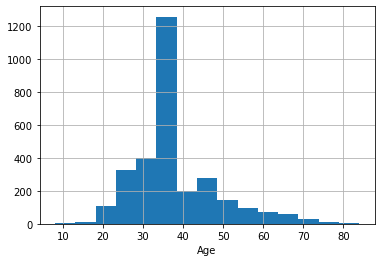

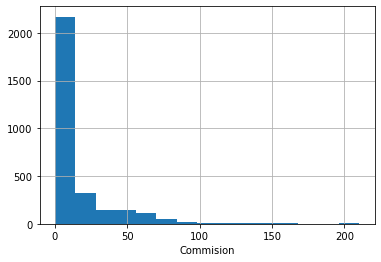

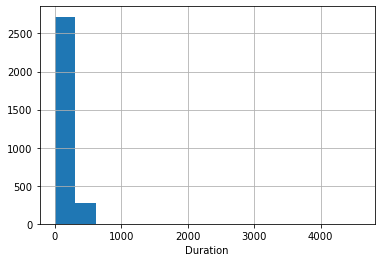

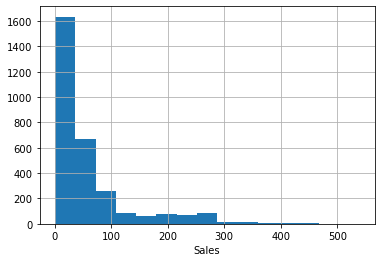

In [13]:
for i in vars_num:
    df[i].hist(bins=15)
    plt.xlabel(i)
    plt.show()

<b>Observations: </b>From the distributions, it seems all the continuous variables are right-skewed, except Age that shows a slightly normal distribution.

### Uni-variate and Multi-variate analysis

### Sales

<AxesSubplot:xlabel='Channel', ylabel='Sales'>

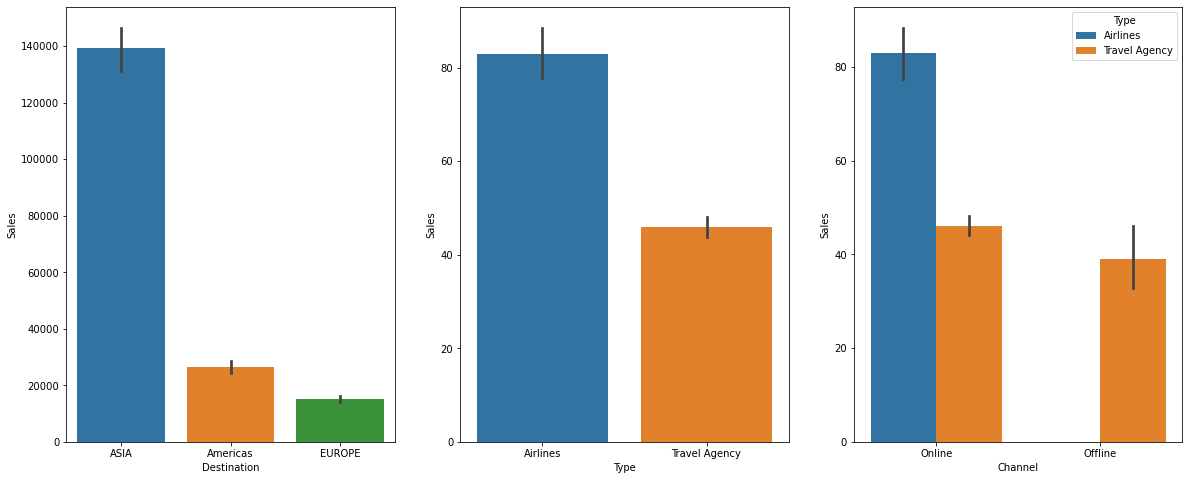

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(20,8))
sns.barplot(data=df, x='Destination', y='Sales', estimator=np.sum, ax=ax[0])
sns.barplot(data=df, x='Type', y='Sales', ax=ax[1])
sns.barplot(data=df, x='Channel', y='Sales', hue='Type', ax=ax[2])

<b>Observations: </b>

- Total Sales are highest in Asia, followed by Americas and lastly Europe
- Sales are higher through Airlines, Online channel
- Sales through Travel agency are through Offline channel only

### Product

<AxesSubplot:xlabel='Product Name', ylabel='Sales'>

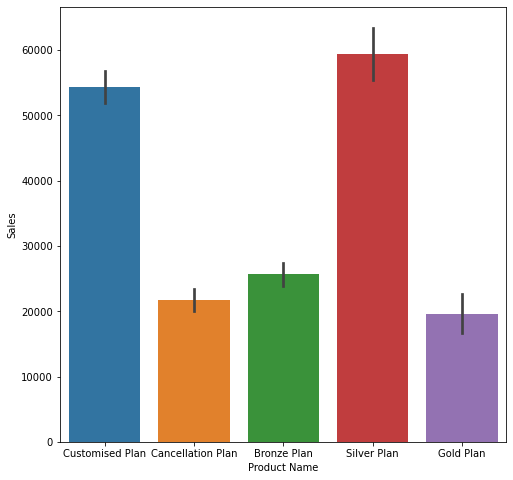

In [15]:
plt.figure(figsize=(8,8))
sns.barplot(data=df, x='Product Name', y='Sales', estimator=np.sum)

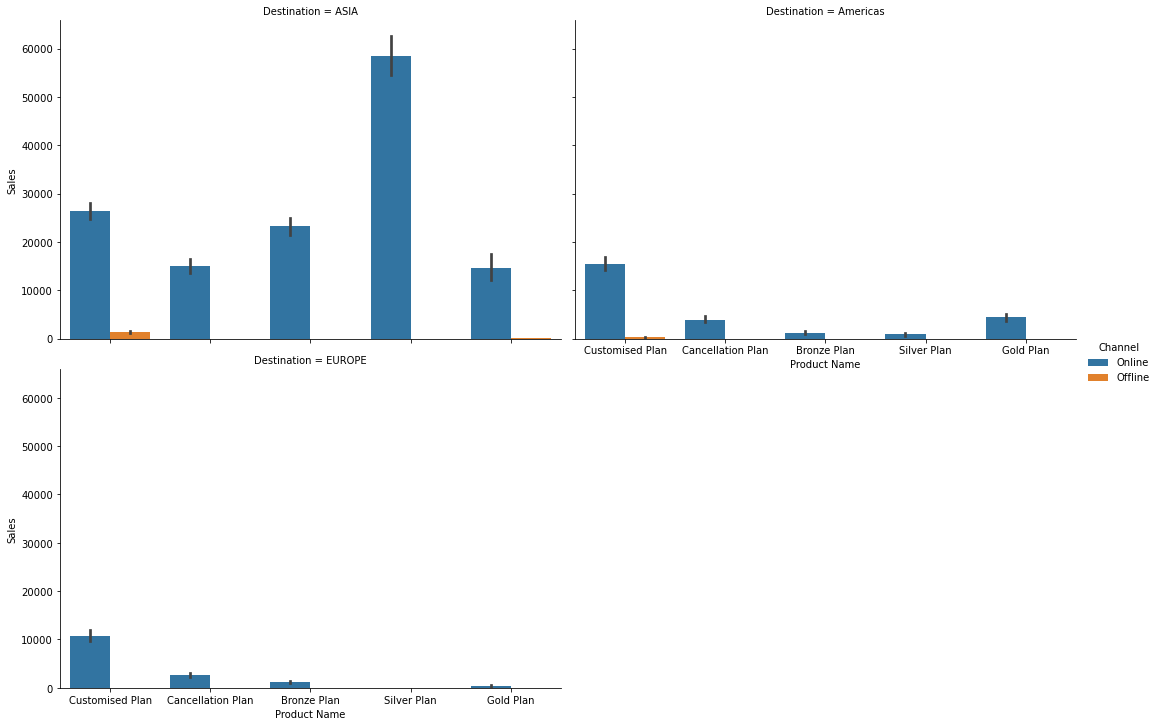

In [16]:
sns.catplot(data=df, x='Product Name', y='Sales', kind='bar', hue='Channel', col='Destination', estimator=np.sum, col_wrap=2, aspect=1.5)

<b>Observations: </b>

- Total Sales are the highest for Silver plan followed by Customized Plan
- As we see, almost 90% of the sales are through Online channel

### Agency Code

<AxesSubplot:xlabel='Agency_Code', ylabel='count'>

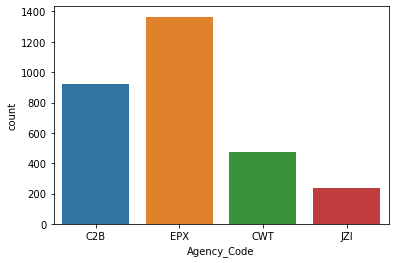

In [17]:
sns.countplot(data=df, x='Agency_Code')

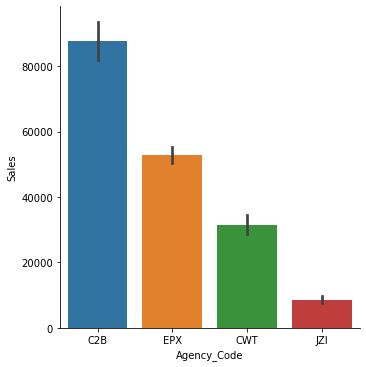

In [18]:
sns.catplot(data=df, x='Agency_Code', y='Sales', kind='bar', estimator=np.sum)

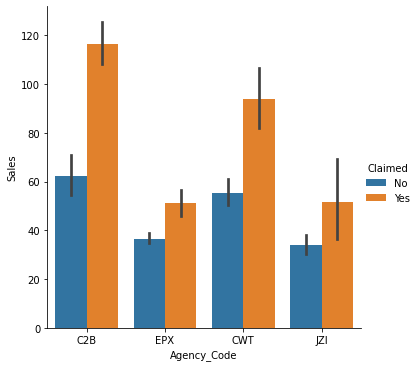

In [19]:
sns.catplot(data=df, x='Agency_Code', y='Sales', kind='bar', hue='Claimed')

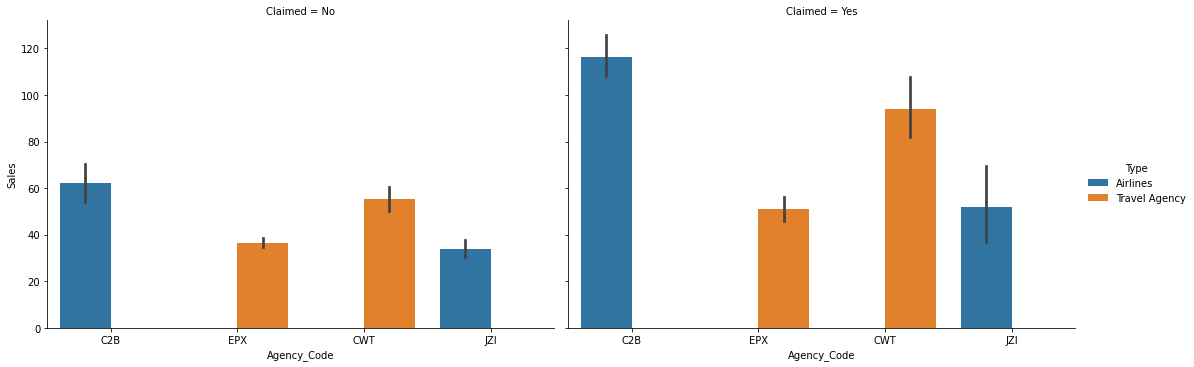

In [20]:
sns.catplot(data=df, x='Agency_Code', y='Sales', kind='bar', hue='Type', col='Claimed', col_wrap=2, aspect=1.5)

<b>Observations: </b>

- Total Sales are the highest for Agency Code C2B folllwed by EPX. Lowest for JZI
- Total Claims are also the highest for Agency Code C2B

### Claimed

In [21]:
df.groupby(['Agency_Code', 'Type', 'Claimed'])['Claimed'].count()

Agency_Code  Type           Claimed
C2B          Airlines       No          364
                            Yes         560
CWT          Travel Agency  No          331
                            Yes         141
EPX          Travel Agency  No         1172
                            Yes         193
JZI          Airlines       No          209
                            Yes          30
Name: Claimed, dtype: int64

In [22]:
df_temp = pd.crosstab(index=df['Destination'], columns=df['Claimed'])
df_temp

Claimed,No,Yes
Destination,,
ASIA,1691,774
Americas,232,88
EUROPE,153,62


<AxesSubplot:xlabel='Destination'>

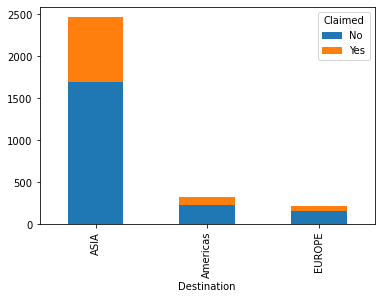

In [23]:
df_temp.plot.bar(stacked=True)

In [24]:
df['Claimed'].value_counts()

No     2076
Yes     924
Name: Claimed, dtype: int64

In [25]:
df_t = df.groupby(['Destination','Product Name','Claimed'])['Claimed'].count()

In [26]:
type(df_t)

pandas.core.series.Series

In [27]:
df_t = df_t.unstack()

In [28]:
df_t.reset_index()

Claimed,Destination,Product Name,No,Yes
0,ASIA,Bronze Plan,379.0,243.0
1,ASIA,Cancellation Plan,528.0,30.0
2,ASIA,Customised Plan,634.0,143.0
3,ASIA,Gold Plan,31.0,56.0
4,ASIA,Silver Plan,119.0,302.0
5,Americas,Bronze Plan,10.0,6.0
6,Americas,Cancellation Plan,65.0,7.0
7,Americas,Customised Plan,149.0,61.0
8,Americas,Gold Plan,6.0,11.0
9,Americas,Silver Plan,2.0,3.0


<AxesSubplot:xlabel='Destination,Product Name'>

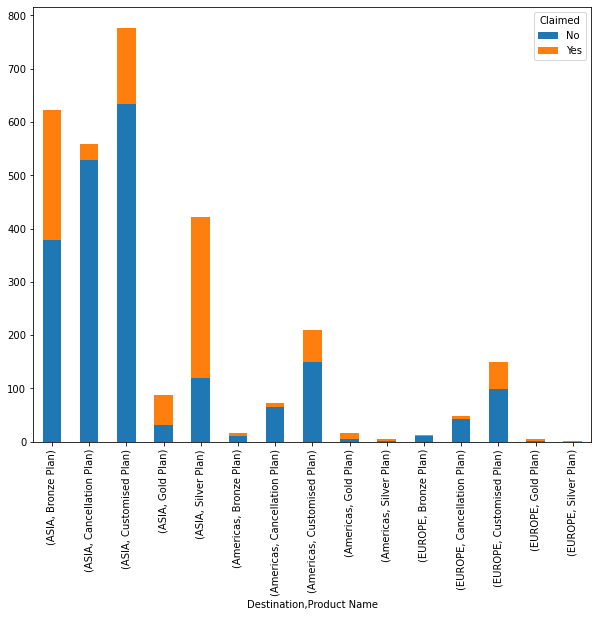

In [29]:
df_t.plot(kind='bar', figsize=(10,8), stacked=True)

In [30]:
df[df['Claimed'] == 'Yes'].groupby(['Destination','Product Name','Type'])['Claimed'].count()

Destination  Product Name       Type         
ASIA         Bronze Plan        Airlines         239
                                Travel Agency      4
             Cancellation Plan  Travel Agency     30
             Customised Plan    Airlines           7
                                Travel Agency    136
             Gold Plan          Airlines          39
                                Travel Agency     17
             Silver Plan        Airlines         298
                                Travel Agency      4
Americas     Bronze Plan        Airlines           6
             Cancellation Plan  Travel Agency      7
             Customised Plan    Travel Agency     61
             Gold Plan          Travel Agency     11
             Silver Plan        Travel Agency      3
EUROPE       Bronze Plan        Airlines           1
                                Travel Agency      1
             Cancellation Plan  Travel Agency      6
             Customised Plan    Travel Agency     50


<b>Observations: </b>

- Number of insurances claimed are highest in Asia for the Silver Plan followed by Bronze Plan. Both are highest through Airlines.
- In Americas and Europe, number of insurances claimed are highest for the customized plan

### Checking for Correlations

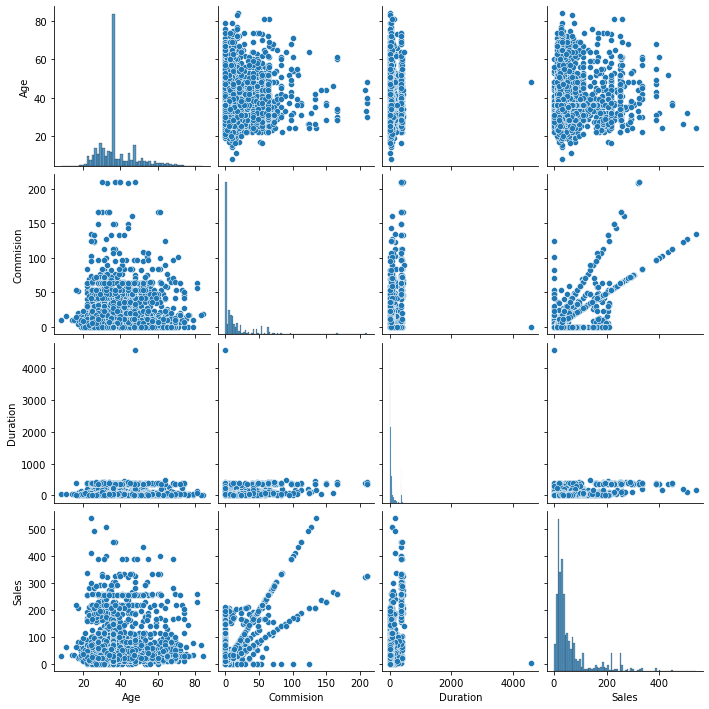

In [119]:
sns.pairplot(df[['Age', 'Commision', 'Duration', 'Sales']])

<AxesSubplot:>

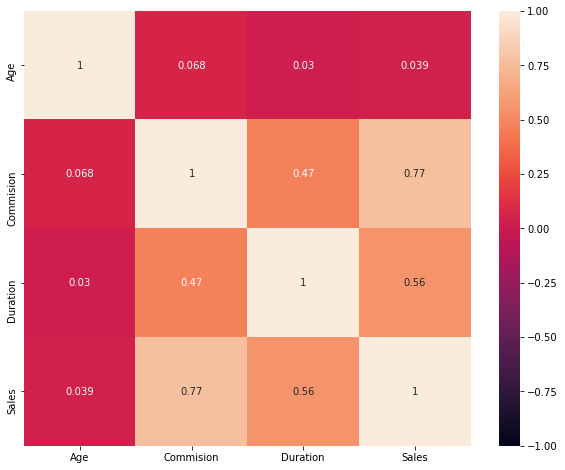

In [31]:
plt.figure(figsize=(10,8))
sns.heatmap(df[['Age', 'Commision', 'Duration', 'Sales']].corr(), annot=True, vmin=-1, vmax=1)

<b>Observations: </b>As expected, there is positive correlation between Sales and Commission.

### Feature Encoding

### As ML models require numbers instead of string or object, let us perform feature encoding on non-numerical columns

In [32]:
vars_cat

['Agency_Code', 'Type', 'Claimed', 'Channel', 'Product Name', 'Destination']

In [33]:
for var in vars_cat:
    df[var] = pd.Categorical(df[var]).codes

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           3000 non-null   int64  
 1   Agency_Code   3000 non-null   int8   
 2   Type          3000 non-null   int8   
 3   Claimed       3000 non-null   int8   
 4   Commision     3000 non-null   float64
 5   Channel       3000 non-null   int8   
 6   Duration      3000 non-null   int64  
 7   Sales         3000 non-null   float64
 8   Product Name  3000 non-null   int8   
 9   Destination   3000 non-null   int8   
dtypes: float64(2), int64(2), int8(6)
memory usage: 111.5 KB


In [35]:
for var in vars_cat:
    find_value_counts(df, var)

2    1365
0     924
1     472
3     239
Name: Agency_Code, dtype: int64
********
Proportion: 
 2    0.455000
0    0.308000
1    0.157333
3    0.079667
Name: Agency_Code, dtype: float64


1    1837
0    1163
Name: Type, dtype: int64
********
Proportion: 
 1    0.612333
0    0.387667
Name: Type, dtype: float64


0    2076
1     924
Name: Claimed, dtype: int64
********
Proportion: 
 0    0.692
1    0.308
Name: Claimed, dtype: float64


1    2954
0      46
Name: Channel, dtype: int64
********
Proportion: 
 1    0.984667
0    0.015333
Name: Channel, dtype: float64


2    1136
1     678
0     650
4     427
3     109
Name: Product Name, dtype: int64
********
Proportion: 
 2    0.378667
1    0.226000
0    0.216667
4    0.142333
3    0.036333
Name: Product Name, dtype: float64


0    2465
1     320
2     215
Name: Destination, dtype: int64
********
Proportion: 
 0    0.821667
1    0.106667
2    0.071667
Name: Destination, dtype: float64




### Proportion of 1s and 0s in the target variable

In [36]:
df['Claimed'].value_counts(normalize=True)

0    0.692
1    0.308
Name: Claimed, dtype: float64

### Let's find the outliers

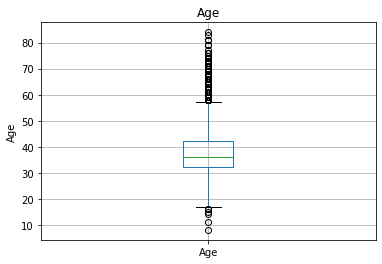

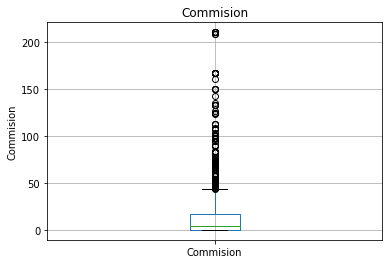

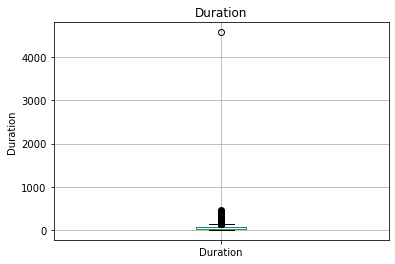

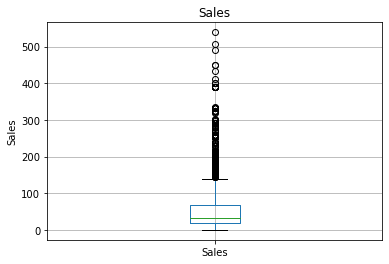

In [37]:
# let's make boxplots to visualise outliers in the continuous variables 

def find_outliers(df, var):
    df.boxplot(column=var)
    plt.title(var)
    plt.ylabel(var)
    plt.show()
    
for var in vars_num:
    find_outliers(df, var)

### 2.2 Data Split: Split the data into test and train, build classification model CART, Random Forest, Artificial Neural Network

### Let us capture the target column into separate vectors for training set and test set

In [38]:
X = df.drop('Claimed', axis=1)
y = df.pop('Claimed')

### Splitting data into training and test set

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=1)

In [40]:
print(X_train.shape)
print(X_test.shape)

(2100, 9)
(900, 9)


In [41]:
print(y_train.shape)
print(y_test.shape)

(2100,)
(900,)


### CART Model

In [42]:
dt_model = DecisionTreeClassifier(criterion = 'gini')

In [43]:
dt_model.fit(X_train, y_train)

DecisionTreeClassifier()

In [44]:
from sklearn import tree

train_char_label = ['No', 'Yes']
Credit_Tree_File = open('C:\Me\GreatLakes\Data Mining\Week5\credit_tree.dot','w')
dot_data = tree.export_graphviz(dt_model, out_file=Credit_Tree_File, feature_names = list(X_train), class_names = list(train_char_label))
#list(X_train) extracts the column names
Credit_Tree_File.close()

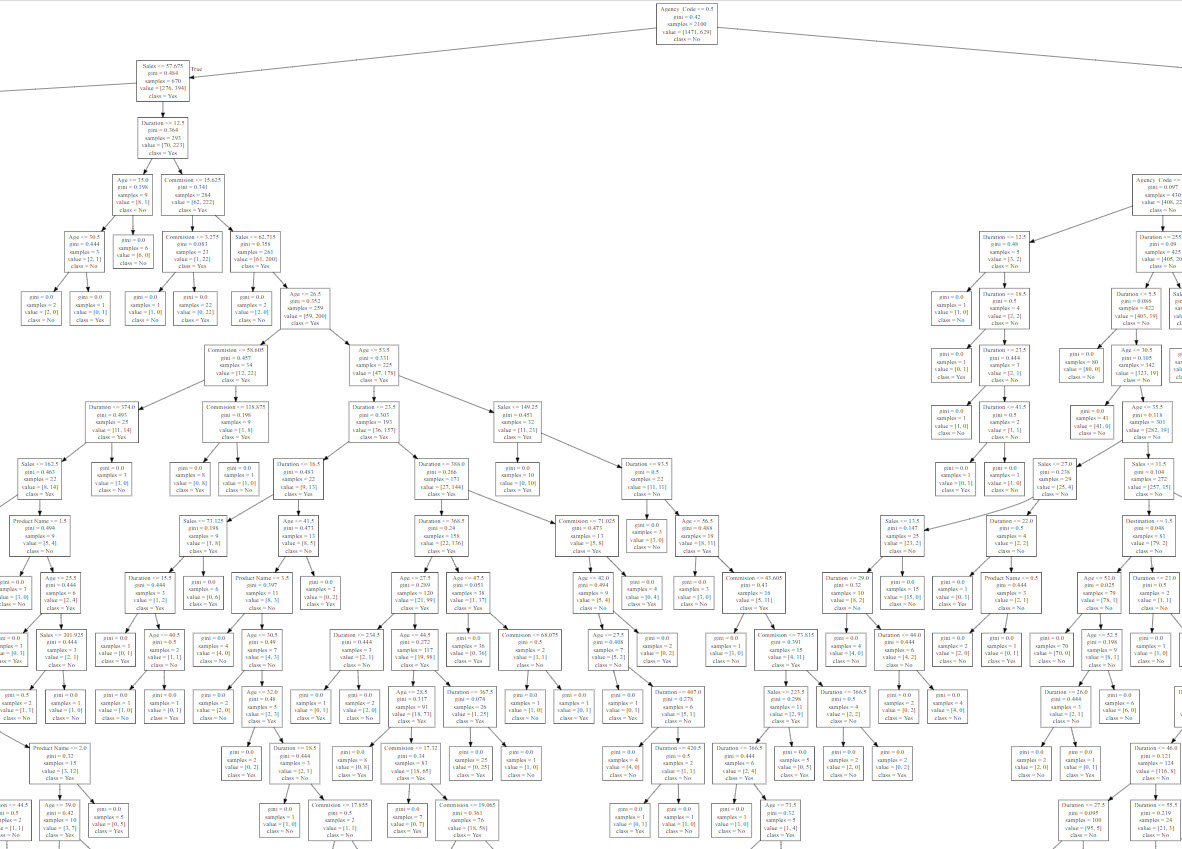

<b>This is a snip of how BIG the tree looks !! It definetely requires to be pruned.</b>

### Variable importance

In [45]:
print (pd.DataFrame(dt_model.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values('Imp',ascending=False))

                   Imp
Duration      0.259531
Sales         0.213348
Agency_Code   0.195996
Age           0.170601
Commision     0.088180
Product Name  0.038196
Destination   0.025679
Channel       0.008469
Type          0.000000


In [46]:
#y_predict = dt_model.predict(X_test)

### Regularising the Decision Tree

### Adding Tuning Parameters and fit the model

In [47]:
#Pruning
reg_dt_model = DecisionTreeClassifier(criterion = 'gini', max_depth=7, min_samples_leaf=30, min_samples_split=90)

In [48]:
reg_dt_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=30, min_samples_split=90)

In [49]:
credit_tree_regularized = open('C:\Me\GreatLakes\Data Mining\Week5\credit_tree_regularized.dot','w')
dot_data = tree.export_graphviz(reg_dt_model, out_file= credit_tree_regularized , feature_names = list(X_train), class_names = list(train_char_label))

credit_tree_regularized.close()

### Variable Importance

In [50]:
print(pd.DataFrame(reg_dt_model.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values('Imp',ascending=False))

                   Imp
Agency_Code   0.566664
Sales         0.247335
Product Name  0.071496
Duration      0.046473
Age           0.044596
Commision     0.023436
Type          0.000000
Channel       0.000000
Destination   0.000000


### Predict on Train and Test dataset

In [51]:
dt_ytrain_predict = reg_dt_model.predict(X_train)
dt_ytest_predict = reg_dt_model.predict(X_test)

In [52]:
dt_ytrain_predict_proba = reg_dt_model.predict_proba(X_train)
dt_ytest_predict_proba = reg_dt_model.predict_proba(X_test)

In [53]:
dt_ytrain_predict

array([0, 0, 1, ..., 0, 0, 1], dtype=int8)

### Model Tuning through GridSearchCV

### We will use Grid Search for finding out the optimal values for hyper parameters

In [54]:
param_grid_dt = {
    'max_depth': [5, 7],
    'min_samples_leaf': [30, 60],
    'min_samples_split': [80, 90, 100],
}

dt = DecisionTreeClassifier()

grid_search_dt = GridSearchCV(estimator=dt, param_grid=param_grid_dt, cv=3)

In [55]:
grid_search_dt.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [5, 7], 'min_samples_leaf': [30, 60],
                         'min_samples_split': [80, 90, 100]})

In [56]:
grid_search_dt.best_params_

{'max_depth': 5, 'min_samples_leaf': 30, 'min_samples_split': 80}

In [57]:
param_grid_dt = {
    'max_depth': [3, 4, 5, 6],
    'min_samples_leaf': [20, 30, 40, 50],
    'min_samples_split': [90, 100, 110, 120],
}

dt = DecisionTreeClassifier()

grid_search_dt = GridSearchCV(estimator=dt, param_grid=param_grid_dt, cv=3)

In [58]:
grid_search_dt.fit(X_train, y_train)
grid_search_dt.best_params_

{'max_depth': 5, 'min_samples_leaf': 30, 'min_samples_split': 120}

In [59]:
param_grid_dt = {
    'max_depth': [5],
    'min_samples_leaf': [30, 40],
    'min_samples_split': [110, 120, 130],
}

dt = DecisionTreeClassifier()

grid_search_dt = GridSearchCV(estimator=dt, param_grid=param_grid_dt, cv=3)

In [60]:
grid_search_dt.fit(X_train, y_train)
grid_search_dt.best_params_

{'max_depth': 5, 'min_samples_leaf': 30, 'min_samples_split': 120}

In [61]:
best_grid_dt = grid_search_dt.best_estimator_
best_grid_dt

DecisionTreeClassifier(max_depth=5, min_samples_leaf=30, min_samples_split=120)

In [62]:
dt_ytrain_predict = best_grid_dt.predict(X_train)
dt_ytest_predict = best_grid_dt.predict(X_test)

### Variable Importance

In [63]:
print(pd.DataFrame(best_grid_dt.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values('Imp',ascending=False))

                   Imp
Agency_Code   0.586832
Sales         0.252143
Product Name  0.074957
Duration      0.031694
Age           0.025030
Commision     0.022083
Type          0.007260
Channel       0.000000
Destination   0.000000


### RandomForest Model

In [113]:
#Build a RandomForestCassifier wit n_estimators 100, max_features 6, and fit it on the training data
rfcl = RandomForestClassifier(n_estimators=100,
                             max_features=6,
                             random_state=0)
rfcl = rfcl.fit(X_train, y_train)

### Predict on Train and Test dataset

In [114]:
rfcl_ytrain_predict = rfcl.predict(X_train)
rfcl_ytest_predict = rfcl.predict(X_test)

rfcl_ytrain_predict_proba = rfcl.predict_proba(X_train)
rfcl_ytest_predict_proba = rfcl.predict_proba(X_test)

### Model tuning using GridSearchCV (tuning the hyperparams)

In [66]:
param_grid_rf = {
    'max_depth': [5, 7],
    'max_features': [5, 6, 7],
    'min_samples_leaf': [30, 50],
    'min_samples_split': [90, 100],
    'n_estimators': [101, 201, 301]
}

rfcl = RandomForestClassifier()

grid_search_rf = GridSearchCV(estimator=rfcl, param_grid=param_grid_rf, cv=3)

In [67]:
grid_search_rf.fit(X_train, y_train)
grid_search_rf.best_params_

{'max_depth': 7,
 'max_features': 7,
 'min_samples_leaf': 30,
 'min_samples_split': 100,
 'n_estimators': 101}

In [68]:
param_grid_rf = {
    'max_depth': [7],
    'max_features': [6, 7, 8],
    'min_samples_leaf': [30, 35],
    'min_samples_split': [100, 110, 120],
    'n_estimators': [101, 201]
}

rfcl = RandomForestClassifier()

grid_search_rf = GridSearchCV(estimator=rfcl, param_grid=param_grid_rf, cv=3)

In [69]:
grid_search_rf.fit(X_train, y_train)
grid_search_rf.best_params_

{'max_depth': 7,
 'max_features': 6,
 'min_samples_leaf': 35,
 'min_samples_split': 120,
 'n_estimators': 201}

In [70]:
best_grid_rf = grid_search_rf.best_estimator_
best_grid_rf

RandomForestClassifier(max_depth=7, max_features=6, min_samples_leaf=35,
                       min_samples_split=120, n_estimators=201)

In [71]:
rfcl_ytrain_predict = best_grid_rf.predict(X_train)
rfcl_ytest_predict = best_grid_rf.predict(X_test)

### Variable Importance

In [72]:
print(pd.DataFrame(best_grid_rf.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values('Imp',ascending=False))

                   Imp
Agency_Code   0.458573
Sales         0.185431
Product Name  0.166680
Commision     0.090378
Duration      0.045166
Age           0.027955
Type          0.020505
Destination   0.005313
Channel       0.000000


### ANN

### Scaling the variables

Feature scaling is required in ANN else features with higher scales may dominate output calculations.

In [73]:
#Initialize an object for StandardScaler
sc = StandardScaler()

In [74]:
X_train_scaled = sc.fit(X_train)
X_train_scaled = sc.transform(X_train)

In [75]:
X_train_scaled = pd.DataFrame(data=X_train_scaled, columns=X_train.columns)
X_train_scaled.head(2)

,Age,Agency_Code,Type,Commision,Channel,Duration,Sales,Product Name,Destination
0,-0.191925,0.728159,0.805203,-0.580954,0.120386,-0.287441,-0.573066,0.246424,-0.439260
1,-0.191925,0.728159,0.805203,-0.580954,0.120386,0.461466,-0.269106,0.246424,1.278517


In [76]:
# Apply the transformation on the test data
X_test_scaled = sc.transform(X_test) 

### Let us create MLP Classifier model and fit it on the scaled dataset

In [77]:
clf = MLPClassifier(hidden_layer_sizes=100, max_iter=5000,
                     solver='sgd', verbose=True,  random_state=21, tol=0.01)

In [78]:
# Fit the model on the training data
clf.fit(X_train_scaled, y_train)

Iteration 1, loss = 0.64459932
Iteration 2, loss = 0.62689739
Iteration 3, loss = 0.60662904
Iteration 4, loss = 0.58889576
Iteration 5, loss = 0.57375106
Iteration 6, loss = 0.56124855
Iteration 7, loss = 0.55072503
Iteration 8, loss = 0.54232804
Iteration 9, loss = 0.53526864
Iteration 10, loss = 0.52917396
Iteration 11, loss = 0.52400864
Iteration 12, loss = 0.51943619
Iteration 13, loss = 0.51564861
Iteration 14, loss = 0.51213112
Iteration 15, loss = 0.50922260
Iteration 16, loss = 0.50660266
Iteration 17, loss = 0.50425722
Iteration 18, loss = 0.50217408
Training loss did not improve more than tol=0.010000 for 10 consecutive epochs. Stopping.


MLPClassifier(hidden_layer_sizes=100, max_iter=5000, random_state=21,
              solver='sgd', tol=0.01, verbose=True)

### Predict on Train and Test dataset

In [79]:
# use the model to predict the data
clf_ytrain_predict = clf.predict(X_train_scaled)
clf_ytest_predict = clf.predict(X_test_scaled)

### Model tuning using GridSearchCV (tuning the hyperparams)

In [80]:
param_grid_clf = {
    'hidden_layer_sizes': [100,200,300,500],
    'max_iter': [3000,5000,6000,7000],
    'solver': ['sgd','adam'],
    'tol': [0.01],
}

nncl = MLPClassifier(random_state=1)

grid_search_clf = GridSearchCV(estimator=nncl, param_grid=param_grid_clf, cv=3)

In [81]:
grid_search_clf.fit(X_train_scaled, y_train)
grid_search_clf.best_params_

{'hidden_layer_sizes': 200, 'max_iter': 3000, 'solver': 'adam', 'tol': 0.01}

In [82]:
param_grid_clf = {
    'hidden_layer_sizes': [150,200,250,300],
    'max_iter': [2000,2500,3000,3500],
    'solver': ['sgd','adam'],
    'tol': [0.01],
}

nncl = MLPClassifier(random_state=1)

grid_search_clf = GridSearchCV(estimator=nncl, param_grid=param_grid_clf, cv=3)

In [83]:
grid_search_clf.fit(X_train_scaled, y_train)
grid_search_clf.best_params_

{'hidden_layer_sizes': 200, 'max_iter': 2000, 'solver': 'adam', 'tol': 0.01}

In [84]:
best_grid_clf = grid_search_clf.best_estimator_
best_grid_clf

MLPClassifier(hidden_layer_sizes=200, max_iter=2000, random_state=1, tol=0.01)

In [85]:
# use the model to predict the data
clf_ytrain_predict = best_grid_clf.predict(X_train_scaled)
clf_ytest_predict = best_grid_clf.predict(X_test_scaled)

---------------------------------------------------------

### 2.3 Performance Metrics: Check the performance of Predictions on Train and Test sets using Accuracy, Confusion Matrix, Plot ROC curve and get ROC_AUC score for each model.

### Let us create a function for ROC AUC

In [86]:
def calc_roc_auc(X, y, model):
    # AUC and ROC for the training data
    # predict probabilities
    probs = model.predict_proba(X)
    # keep probabilities for the positive outcome only
    probs = probs[:, 1]
    # calculate AUC
    auc = roc_auc_score(y, probs)
    print('AUC: %.3f' % auc)
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(y, probs)
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    # show the plot
    plt.show()

### ROC AUC score for Decision Tree

AUC: 0.837


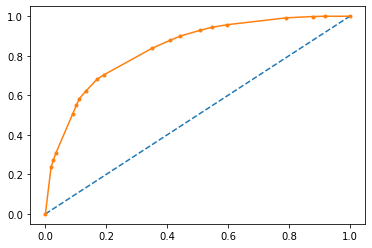

In [87]:
calc_roc_auc(X_train, y_train, best_grid_dt)

AUC: 0.800


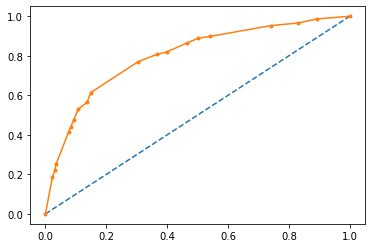

In [88]:
calc_roc_auc(X_test, y_test, best_grid_dt)

Area under the curve on the training data is 84%, and for the test data is close at 80%.

### Classification report, confusion matrix and Accuracy score for CART

### Evaluating model performance on training data

In [89]:
print(classification_report(y_train, dt_ytrain_predict))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1471
           1       0.69      0.58      0.63       629

    accuracy                           0.80      2100
   macro avg       0.76      0.74      0.75      2100
weighted avg       0.79      0.80      0.79      2100



### Evaluating model performance on testing data

In [90]:
print(classification_report(y_test, dt_ytest_predict))

              precision    recall  f1-score   support

           0       0.78      0.91      0.84       605
           1       0.71      0.47      0.57       295

    accuracy                           0.77       900
   macro avg       0.75      0.69      0.70       900
weighted avg       0.76      0.77      0.75       900



------------
Recall = (TP) / (TP+FN)

TP is the number of true positives, and FP is the number of false positives. 

Recall = (TP) / (TP+FN)

On the Testing dataset, the model is correctly identifying 91% in class 0s and only 47% in class 1s.

In [91]:
best_grid_dt.score(X_train, y_train)

0.7971428571428572

In [92]:
best_grid_dt.score(X_test, y_test)

0.7655555555555555

A confusion matrix is a summary of prediction results - 

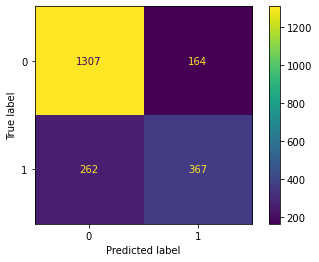

In [93]:
plot_confusion_matrix(best_grid_dt, X_train, y_train)

Here, we can see that there are 262 datapoints predicted at False Negative and 164 datapoints as False Positive.

### ROC AUC score for Random Forest

### Let us first try to check the ROC AUC score for not regularized model

AUC: 1.000


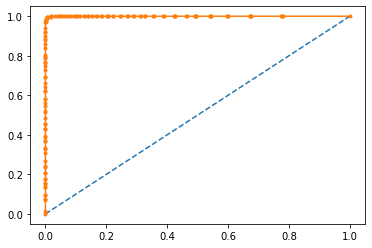

In [115]:
calc_roc_auc(X_train, y_train, rfcl)

AUC: 0.799


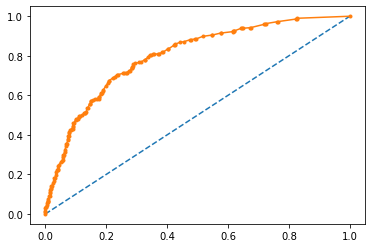

In [117]:
calc_roc_auc(X_test, y_test, rfcl)

### Looking at the AUC, we have 100% results on the training data, whereas on the Test data, performance is lower.  
 
This is because overfitting has happened on the training data, and therefore the model is weak in generalizing and predicting any new data.

This makes evident the necessity to tune the hyper parameters.

### Now let us check the performance on the tuned model

AUC: 0.843


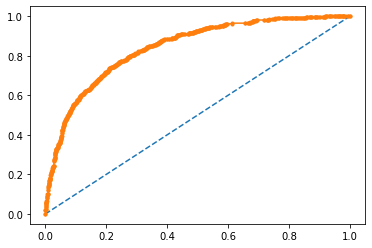

In [94]:
calc_roc_auc(X_train, y_train, best_grid_rf)

AUC: 0.817


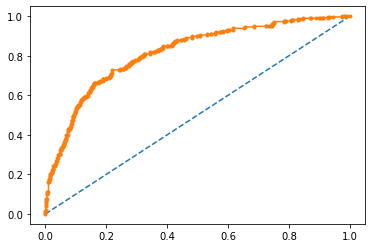

In [95]:
calc_roc_auc(X_test, y_test, best_grid_rf)

Area under the curve on the training data is 84%, and for the test data is close at 82% which is quite good.

### Classification report, confusion matrix and Accuracy score for Random Forest

In [96]:
print(classification_report(y_train, rfcl_ytrain_predict))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1471
           1       0.71      0.56      0.63       629

    accuracy                           0.80      2100
   macro avg       0.77      0.73      0.74      2100
weighted avg       0.79      0.80      0.79      2100



In [97]:
print(classification_report(y_test, rfcl_ytest_predict))

              precision    recall  f1-score   support

           0       0.77      0.92      0.84       605
           1       0.72      0.45      0.55       295

    accuracy                           0.76       900
   macro avg       0.75      0.68      0.70       900
weighted avg       0.76      0.76      0.74       900



On the Training dataset, the model is correctly identifying 90% in class 0s and 56% in class 1s.

On the Testing dataset, the model is correctly identifying 92% in class 0s and only 45% in class 1s.

In [98]:
best_grid_rf.score(X_train, y_train)

0.7995238095238095

In [99]:
best_grid_rf.score(X_test, y_test)

0.7622222222222222

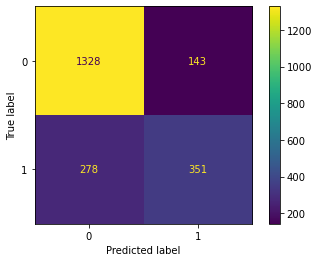

In [100]:
plot_confusion_matrix(best_grid_rf, X_train, y_train)

Here, we can see that there are 272 datapoints predicted at False Negative and 143 datapoints as False Positive.

### ROC AUC score for ANN

AUC: 0.818


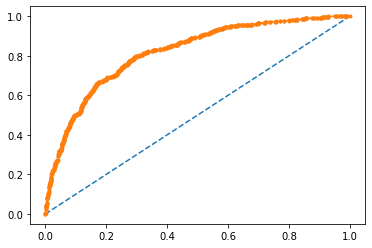

In [101]:
calc_roc_auc(X_train_scaled, y_train, best_grid_clf)

AUC: 0.804


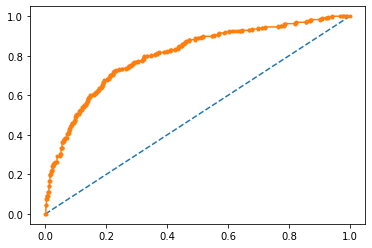

In [102]:
calc_roc_auc(X_test_scaled, y_test, best_grid_clf)

Area under the curve on the training data is 82%, and for the test data is close at 80%.

### Classification report, confusion matrix and Accuracy score for ANN

In [103]:
print(classification_report(y_train, clf_ytrain_predict))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85      1471
           1       0.67      0.51      0.57       629

    accuracy                           0.78      2100
   macro avg       0.74      0.70      0.71      2100
weighted avg       0.77      0.78      0.77      2100



In [104]:
print(classification_report(y_test, clf_ytest_predict))

              precision    recall  f1-score   support

           0       0.77      0.92      0.84       605
           1       0.72      0.43      0.54       295

    accuracy                           0.76       900
   macro avg       0.75      0.68      0.69       900
weighted avg       0.75      0.76      0.74       900



On the Training dataset, the model is correctly identifying 89% in class 0s and 51% in class 1s.

On the Testing dataset, the model is correctly identifying 92% in class 0s and only 43% in class 1s.

In [105]:
best_grid_clf.score(X_train_scaled, y_train)

0.7757142857142857

In [106]:
best_grid_clf.score(X_test_scaled, y_test)

0.76

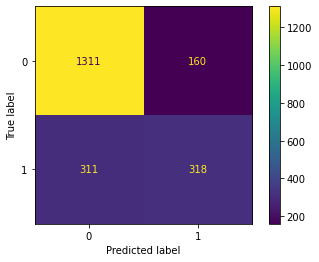

In [107]:
plot_confusion_matrix(best_grid_clf, X_train_scaled, y_train)

Here, we can see that there are 311 datapoints predicted at False Negative and 160 datapoints as False Positive.

### 2.4 Final Model: Compare all the model and write an inference which model is best/optimized.

### <u>CART statistics</u>

<b>Train Data</b>

- AUC score: 0.847
- Accuracy: 0.798
- Recall: 0.58
- Precision: 0.69
- F1 score: 0.63

<b>Test Data</b>

- AUC score: 0.795
- Accuracy: 0.766
- Recall: 0.47
- Precision: 0.71
- F1 score: 0.57

### <u>RF statistics</u>

<b>Train Data</b>

- AUC score: 0.848
- Accuracy: 0.8
- Recall: 0.56
- Precision: 0.71
- F1 score: 0.63

<b>Test Data</b>

- AUC score: 0.817
- Accuracy: 0.76
- Recall: 0.44
- Precision: 0.73
- F1 score: 0.55

### <u>ANN statistics</u>

<b>Train Data</b>

- AUC score: 0.818
- Accuracy: 0.78
- Recall: 0.51
- Precision: 0.67
- F1 score: 0.57

<b>Test Data</b>

- AUC score: 0.804
- Accuracy: 0.76
- Recall: 0.43
- Precision: 0.72
- F1 score: 0.54

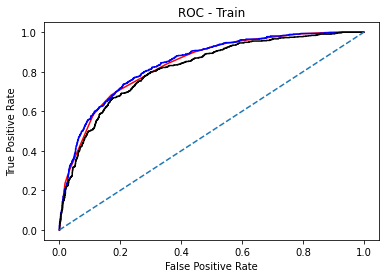

In [108]:
dt_fpr, dt_tpr,_=roc_curve(y_train,best_grid_dt.predict_proba(X_train)[:,1])
rf_fpr, rf_tpr,_=roc_curve(y_train,best_grid_rf.predict_proba(X_train)[:,1])
nn_fpr, nn_tpr,_=roc_curve(y_train,best_grid_clf.predict_proba(X_train_scaled)[:,1])

plt.plot(dt_fpr,dt_tpr, label='DT', color='red')
plt.plot(rf_fpr,rf_tpr, label='RF', color='blue')
plt.plot(nn_fpr,nn_tpr, label='NN', color='black')

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Train')
plt.show()

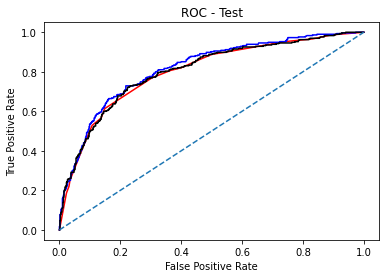

In [109]:
dt_fpr, dt_tpr,_=roc_curve(y_test,best_grid_dt.predict_proba(X_test)[:,1])
rf_fpr, rf_tpr,_=roc_curve(y_test,best_grid_rf.predict_proba(X_test)[:,1])
nn_fpr, nn_tpr,_=roc_curve(y_test,best_grid_clf.predict_proba(X_test_scaled)[:,1])

plt.plot(dt_fpr,dt_tpr, label='DT', color='red')
plt.plot(rf_fpr,rf_tpr, label='RF', color='blue')
plt.plot(nn_fpr,nn_tpr, label='NN', color='black')

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Test')
plt.show()

### Based on the aforemetioned statistics and combined ROC plots, I think I would go for Random Forest model as it has slightly better AUC score, Accuracy, Recall Precision and F1 score.

--------------------------------------------------

### 2.5 Inference: Based on the whole Analysis, what are the business insights and recommendations

From the given dataset, we can see that Sales are the highest in the Asian continent, followed by Americas and lastly Europe. Overall, Sales are higher through the Online channel. Almost 90% of the Sales are through Online channel.
Offline sales are through Travel agency firms only.

Agency-wise, the Sales are highest for C2B but at the same time number of claims are also the highestf or this agency code. The plans sold by this may need to be investigated.
Total Sales are the lowest for JZI agency. More marketing and promotional strategies may be recommended to increase Sales.

We also saw that number of insurances claimed are highest in Asia for the Silver Plan followed by Bronze Plan. Both are highest through Airlines. In Americas and Europe, number of insurances claimed are highest for the customized plan. These plan may require some revisiting and deep-dive as to why?
On the other hand, Cancellation plan in ASIA has lowest number of claims. This plan may need more promotions so it see higher adaption.

Based on the RF model, we have got 82% accuracy in determining claim status, so when a customer books a ticket online through airlines, we can analyze his/her data and recommend appropriate insurance plan suiting his/her needs.